# Task 1

---

## Web scraping and analysis

This Jupyter notebook includes some code to get you started with web scraping. We will use a package called `BeautifulSoup` to collect the data from the web. Once you've collected your data and saved it into a local `.csv` file you should start with your analysis.

### Scraping data from Skytrax

If you visit [https://www.airlinequality.com] you can see that there is a lot of data there. For this task, we are only interested in reviews related to British Airways and the Airline itself.

If you navigate to this link: [https://www.airlinequality.com/airline-reviews/british-airways] you will see this data. Now, we can use `Python` and `BeautifulSoup` to collect all the links to the reviews and then to collect the text data on each of the individual review links.

In [8]:
# Importing all the necessary libraries
import requests
from bs4 import BeautifulSoup
import json
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import re
import nltk
from nltk.stem import WordNetLemmatizer
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from PIL import Image
from collections import Counter
from wordcloud import WordCloud
from textblob import TextBlob
import warnings
warnings.filterwarnings('ignore')
plt.style.use('ggplot')
sw = stopwords.words('english')
lemma = WordNetLemmatizer()

In [9]:
# Function to scrape the British Airways Airline reviews.
def scrape_data(pages):
    reviews = []

    for i in range (1, pages + 1):
        print (f"Scraping page {i}")
        page_size = 100
        base_url = "https://www.airlinequality.com/airline-reviews/british-airways"

        # Create a URL to collect links from paginates data
        url = f"{base_url}/page/{i}/?sortby=post_date%3ADesc&pagesize={page_size}"

        # Collect the HTML Data from this page
        response = requests.get(url)

        # Parsing the content
        content = response.content
        parsed_content = BeautifulSoup(content, 'html.parser')
        rating_score = parsed_content.find_all("div", {"class": "rating-10"})[1:]
        profile = parsed_content.find_all("div", {"class": "body"})

        for index, passenger in enumerate (profile):
            profile = {}
            rating = rating_score[index].get_text()
            header = passenger.find("h2", {"class": "text_header"}).get_text()
            loc_time = passenger.find("h3", {"class": "text_sub_header"}).get_text()
            review = passenger.find("div", {"class": "text_content"}).get_text()
            review_table = passenger.find('table', {"class": "review-ratings"})
            if review_table is not None:
                recommend = review_table.find_all('td', {"class": "review-value"})[-1].get_text()
                cabin_flown = review_table.find('td', text="Seat Type").find_next_sibling('td').get_text()

            else:
                recommend = "N/A"
                cabin_flown = "N/A"

            profile.update([('header', header),
                            ('Seat Type', cabin_flown),
                            ('review', review),
                            ('loc_time', loc_time),
                            ('rating', rating),
                            ('recommend', recommend)])
            reviews.append(profile)
        print (f"    ---> {len(reviews)} total reviews")
    return reviews

In [10]:
# Creating the dataset of reviews
reviews_list = scrape_data(20)
df = pd.DataFrame(reviews_list)
df.head()

Scraping page 1
    ---> 100 total reviews
Scraping page 2
    ---> 200 total reviews
Scraping page 3
    ---> 300 total reviews
Scraping page 4
    ---> 400 total reviews
Scraping page 5
    ---> 500 total reviews
Scraping page 6
    ---> 600 total reviews
Scraping page 7
    ---> 700 total reviews
Scraping page 8
    ---> 800 total reviews
Scraping page 9
    ---> 900 total reviews
Scraping page 10
    ---> 1000 total reviews
Scraping page 11
    ---> 1100 total reviews
Scraping page 12
    ---> 1200 total reviews
Scraping page 13
    ---> 1300 total reviews
Scraping page 14
    ---> 1400 total reviews
Scraping page 15
    ---> 1500 total reviews
Scraping page 16
    ---> 1600 total reviews
Scraping page 17
    ---> 1700 total reviews
Scraping page 18
    ---> 1800 total reviews
Scraping page 19
    ---> 1900 total reviews
Scraping page 20
    ---> 2000 total reviews


,header,Seat Type,review,loc_time,rating,recommend
0,"""Excellent service""",First Class,✅ Trip Verified | Excellent service both on th...,\n\nIan Sinclair (United Kingdom) 24th January...,\n9/10\n,yes
1,"""Sound dinner service""",Business Class,✅ Trip Verified | Good lounge at Cape Town. O...,\n\nE Smyth (United Kingdom) 24th January 2023,\n9/10\n,yes
2,"""A really excellent journey""",Business Class,✅ Trip Verified | A really excellent journey....,\n\n Horton (United Kingdom) 23rd January 2023,\n9/10\n,yes
3,"""flight was one of the worst""",Business Class,✅ Trip Verified | This flight was one of the ...,\n\nMarian Benedikovic (United Kingdom) 21st J...,\n2/10\n,no
4,"""there is a race to the bottom""",Economy Class,Not Verified | It seems that there is a race t...,\n\nThomas Kowalski (United States) 19th Janua...,\n3/10\n,no


Congratulations! Now you have your dataset for this task! The loops above collected 1000 reviews by iterating through the paginated pages on the website. However, if you want to collect more data, try increasing the number of pages!

 The next thing that you should do is clean this data to remove any unnecessary text from each of the rows. For example, "✅ Trip Verified" can be removed from each row if it exists, as it's not relevant to what we want to investigate.

---

# Cleaning the data

In [11]:
# Function to clean the rating column
def clean_rating(corpus):
    word = re.sub('\n',' ', corpus)                     # Remove the new line characters
    word = word.split('/')[0]                       # Get the actual rating
    return word


# Function to clean the header column
def clean_header(corpus):
    word = corpus.lower()                            # Converting content to lowercase
    word = re.sub('[^a-zA-Z0-9]',' ', word)          # Removing any special characters
    word = word_tokenize(word)
    word = ' '.join(lemma.lemmatize(i) for i in word if i not in sw)
    return word


# Function to clean the review column
def clean_review(corpus):
    word = corpus.split('|')                          # Removing the characters before |
    if len(word) > 1:
        word = word[1]
    else:
        word = word[0]
    word = word.lower()                               # Converting to lowercase
    word = re.sub('[^a-zA-Z0-9]',' ', word)           # Removing any special characters
    word = word_tokenize(word)
    word = ' '.join(lemma.lemmatize(i) for i in word if i not in sw)
    return word


# Function to clean the location and time column
def clean_loc_time(corpus):
    full = corpus.split('(')

    if len(full) > 1:
        full = full [1]
    else:
        full = full[0]

    full = full.split(')')                              # Getting the location and date
    return full


# Applying all the clean functions together for their respective columns
def clean_scraped_data(df):
    df['header'] = df['header'].apply(clean_header)
    df['rating'] = df['rating'].apply(clean_rating)
    df['review'] = df['review'].apply(clean_review)
    split = pd.DataFrame(df['loc_time'].apply(clean_loc_time).tolist(), columns=['country', 'date'])
    df = pd.concat([df, split], axis=1)
    df['date'] = pd.to_datetime(df['date'])
    df.drop(['loc_time'], axis=1, inplace=True)
    return df



In [12]:
# Creating the dataset of reviews
reviews_list = scrape_data(20)
df = pd.DataFrame(reviews_list)
df = clean_scraped_data(df)
df.head()

Scraping page 1
    ---> 100 total reviews
Scraping page 2
    ---> 200 total reviews
Scraping page 3
    ---> 300 total reviews
Scraping page 4
    ---> 400 total reviews
Scraping page 5
    ---> 500 total reviews
Scraping page 6
    ---> 600 total reviews
Scraping page 7
    ---> 700 total reviews
Scraping page 8
    ---> 800 total reviews
Scraping page 9
    ---> 900 total reviews
Scraping page 10
    ---> 1000 total reviews
Scraping page 11
    ---> 1100 total reviews
Scraping page 12
    ---> 1200 total reviews
Scraping page 13
    ---> 1300 total reviews
Scraping page 14
    ---> 1400 total reviews
Scraping page 15
    ---> 1500 total reviews
Scraping page 16
    ---> 1600 total reviews
Scraping page 17
    ---> 1700 total reviews
Scraping page 18
    ---> 1800 total reviews
Scraping page 19
    ---> 1900 total reviews
Scraping page 20
    ---> 2000 total reviews


,header,Seat Type,review,rating,recommend,country,date
0,excellent service,First Class,excellent service ground board first class pro...,9,yes,United Kingdom,2023-01-24
1,sound dinner service,Business Class,good lounge cape town time departure drink hig...,9,yes,United Kingdom,2023-01-24
2,really excellent journey,Business Class,really excellent journey lounge overcrowded la...,9,yes,United Kingdom,2023-01-23
3,flight one worst,Business Class,flight one worst ever life wanted pamper bough...,2,no,United Kingdom,2023-01-21
4,race bottom,Economy Class,seems race bottom amongst airline even check b...,3,no,United States,2023-01-19


---
### Checking for Missing Values

In [13]:
df.isna().sum()

header       0
Seat Type    0
review       0
rating       0
recommend    0
country      0
date         0
dtype: int64

In [16]:
df.to_csv("C:/Users/User/Desktop/Internship Projects/BA Web Scraping Project/data/BA_cleaned_reviews.csv")

---
# Data Analysis

In [17]:
# Converting any numerical features to int
df = df[df['rating']!='\r                         na\r                     ']
df ['rating'] = df['rating'].astype('Int64')

In [18]:
df.dtypes

header               object
Seat Type            object
review               object
rating                Int64
recommend            object
country              object
date         datetime64[ns]
dtype: object

In [19]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2000 entries, 0 to 1999
Data columns (total 7 columns):
 #   Column     Non-Null Count  Dtype         
---  ------     --------------  -----         
 0   header     2000 non-null   object        
 1   Seat Type  2000 non-null   object        
 2   review     2000 non-null   object        
 3   rating     2000 non-null   Int64         
 4   recommend  2000 non-null   object        
 5   country    2000 non-null   object        
 6   date       2000 non-null   datetime64[ns]
dtypes: Int64(1), datetime64[ns](1), object(5)
memory usage: 127.0+ KB


The primary purpose of this project is to determine what is not going well with the customers and change it. Indicating that we need to figure out the overall rating and

AxesSubplot(0.125,0.11;0.775x0.77)


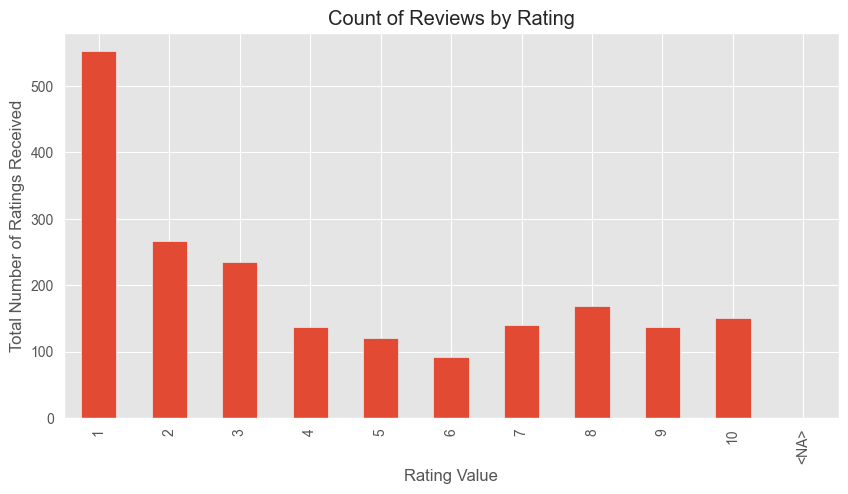

In [20]:
count_rating_reviews = df['rating'].value_counts(dropna=False).sort_index().plot(kind='bar', figsize=(10,5))
count_rating_reviews.set (title = "Count of Reviews by Rating",
                          xlabel = "Rating Value",
                          ylabel = "Total Number of Ratings Received")
print(count_rating_reviews)
plt.show()

### Creating a Pie Chart showing the total number of recommendations

Text(0.5, 1.0, 'Pie Chart of the Total Recommendations by Category')

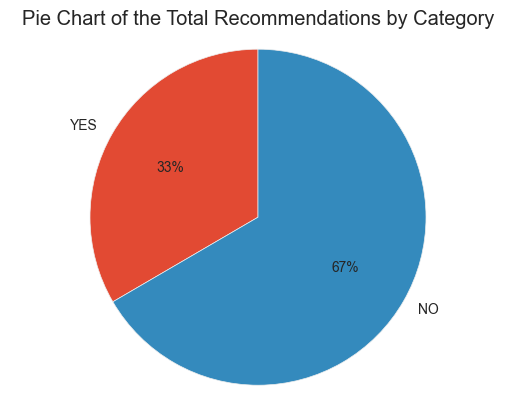

In [21]:
fig = plt.figure()
recommend_yes = df[df['recommend'] == 'yes']
recommend_no = df[df['recommend'] == 'no']

x = [len(recommend_yes), len(recommend_no)]
plt.pie(x, labels = ['YES', 'NO'], startangle=90, autopct='%.f%%')
plt.axis('equal')
plt.title('Pie Chart of the Total Recommendations by Category')

Time to determine what could be the root cause for these unsatisfied customers.

You can choose which specific categories to select from the original data. It can be:

    1. Travel Class
    2. Travel Routes
    3. Travel Dates
    4. Cabin Staff Service

And many more. For my analysis I chose Travel Class

In [22]:
count_seat_type = df['Seat Type'].value_counts(normalize=True)*100
count_seat_type

Economy Class      54.35
Business Class     30.95
Premium Economy     9.45
First Class         5.25
Name: Seat Type, dtype: float64

Let's determine what percentage of these travellers are unsatisfied. This is determined through the number of bad reviews given. For this analysis, a bad review is registered whenever the overall rating is below 4. A fair review is between 4 and 7. An excellent review is between 7 and 10

In [23]:
# First lets establish the review categories
df["Overall Rating"] = "Bad"
df.loc[(df['rating'] > 4) & (df['rating'] <= 7), "Overall Rating"] = 'Fair'
df.loc[(df['rating'] > 7) & (df['rating'] <= 10), "Overall Rating"] = 'Excellent'
df.head()

,header,Seat Type,review,rating,recommend,country,date,Overall Rating
0,excellent service,First Class,excellent service ground board first class pro...,9,yes,United Kingdom,2023-01-24,Excellent
1,sound dinner service,Business Class,good lounge cape town time departure drink hig...,9,yes,United Kingdom,2023-01-24,Excellent
2,really excellent journey,Business Class,really excellent journey lounge overcrowded la...,9,yes,United Kingdom,2023-01-23,Excellent
3,flight one worst,Business Class,flight one worst ever life wanted pamper bough...,2,no,United Kingdom,2023-01-21,Bad
4,race bottom,Economy Class,seems race bottom amongst airline even check b...,3,no,United States,2023-01-19,Bad


In [24]:
df_overall_rating = df["Overall Rating"].value_counts().to_frame().sort_index()
df_overall_rating

,Overall Rating
Bad,1190
Excellent,457
Fair,353


In [25]:
df_overall_rating = df["Overall Rating"].value_counts(normalize=True)*100
df_overall_rating

Bad          59.50
Excellent    22.85
Fair         17.65
Name: Overall Rating, dtype: float64

In [26]:
bad_review_data = df[df["Overall Rating"] == 'Bad']['Seat Type'].value_counts()
bad_review_data

Economy Class      700
Business Class     329
Premium Economy    115
First Class         46
Name: Seat Type, dtype: int64

In [27]:
bad_review_data = df[df["Overall Rating"] == 'Bad']['Seat Type'].value_counts(normalize=True)*100
bad_review_data

Economy Class      58.823529
Business Class     27.647059
Premium Economy     9.663866
First Class         3.865546
Name: Seat Type, dtype: float64

AxesSubplot(0.125,0.11;0.775x0.77)


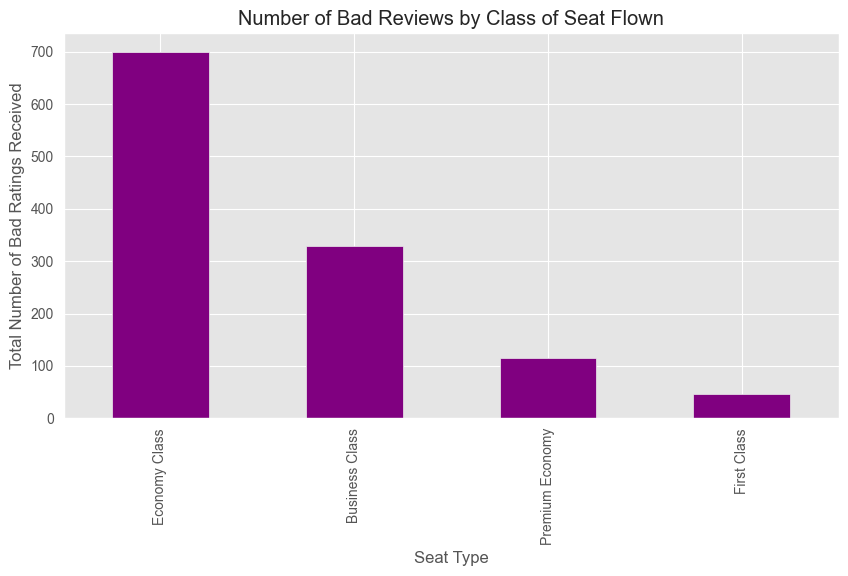

In [28]:
bad_review_data = df[df["Overall Rating"] == 'Bad']['Seat Type'].value_counts().plot(kind='bar', figsize=(10,5), color="purple")
bad_review_data.set (title = "Number of Bad Reviews by Class of Seat Flown",
                          xlabel = "Seat Type",
                          ylabel = "Total Number of Bad Ratings Received")
print(bad_review_data)
plt.show()

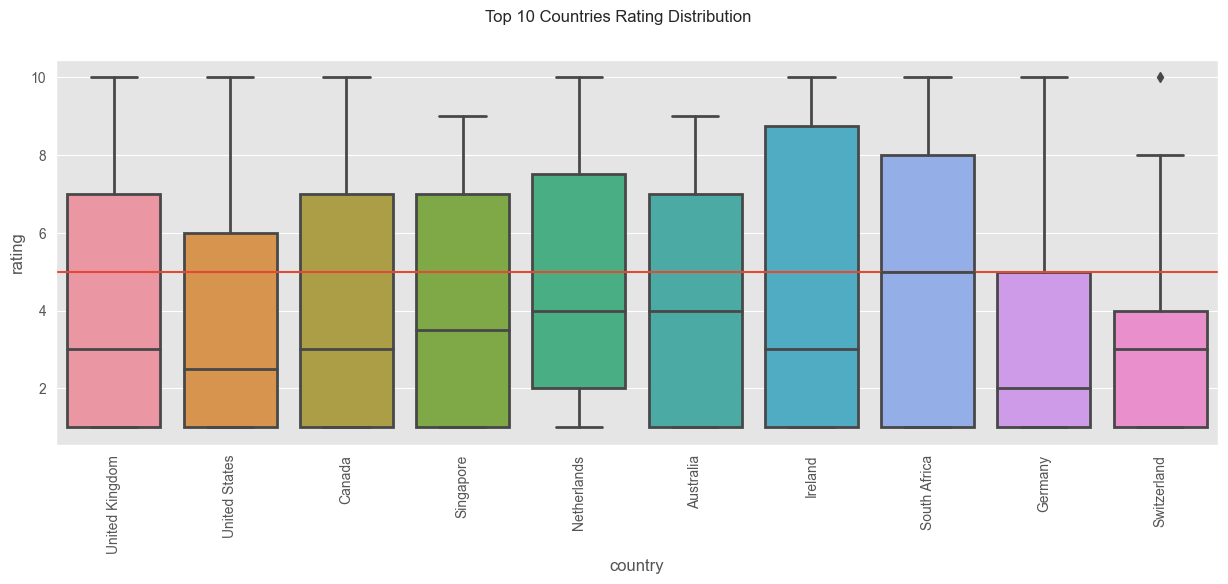

In [29]:
top_10_group = df.groupby(['country']).size().reset_index().sort_values(0, ascending = False).head(10)
top_10_list = top_10_group['country'].tolist()
top_10_country = df[df['country'].isin(top_10_list)]
fig, ax = plt.subplots()
fig.set_size_inches(15, 5)
ax = sns.boxplot(x ='country',
                    y = 'rating',
                    data = top_10_country,
                    linewidth = 2)
ax.axhline(5)
plt.suptitle('Top 10 Countries Rating Distribution')
plt.xticks(rotation=90)
plt.show()

---
# Sentiment Analysis


In [30]:
review_yes = recommend_yes['review'].to_list()
review_no = recommend_no['review'].to_list()

## Top 20 Most Common Words in the Reviews

In [31]:
positive = ' '.join(review_yes)
positive_count = Counter(word_tokenize(positive))
positive_count = dict(sorted(positive_count.items(), key=lambda x:x[1], reverse=True))

negative = ' '.join(review_no)
negative_count = Counter(word_tokenize(negative))
negative_count = dict(sorted(negative_count.items(), key=lambda x:x[1], reverse=True))

### Function to Plot the Word Cloud

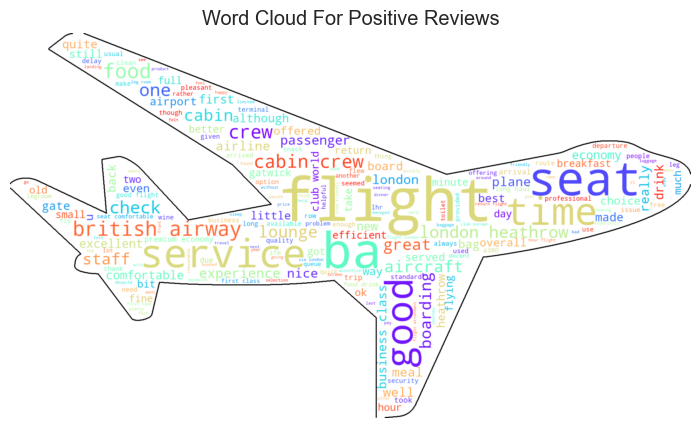

In [34]:

def plot_wordCloud(data:list, title:str):
    mask = np.array(Image.open("plane.png"))
    wordcloud = WordCloud(background_color = "white",
                          max_words = 200,
                          mask=mask, contour_width=3,
                          colormap = 'rainbow').generate(' '.join(data))
    plt.figure(figsize = (12,5))
    plt.imshow(wordcloud, interpolation = 'bilinear')
    plt.title(title)
    plt.axis("off")
    return plt.show()

plot_wordCloud(review_yes,'Word Cloud For Positive Reviews')


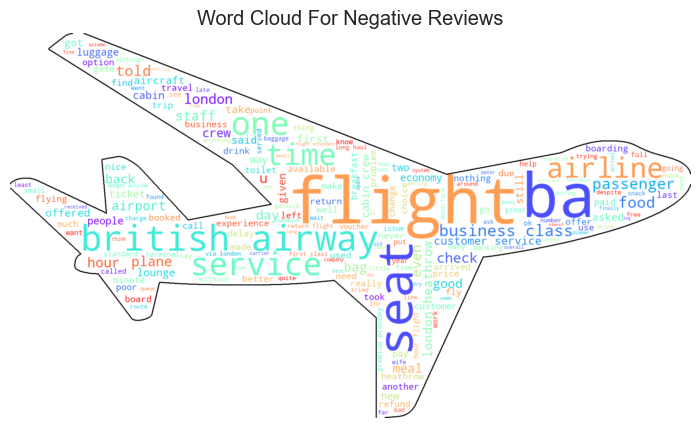

In [35]:
plot_wordCloud(review_no,'Word Cloud For Negative Reviews')


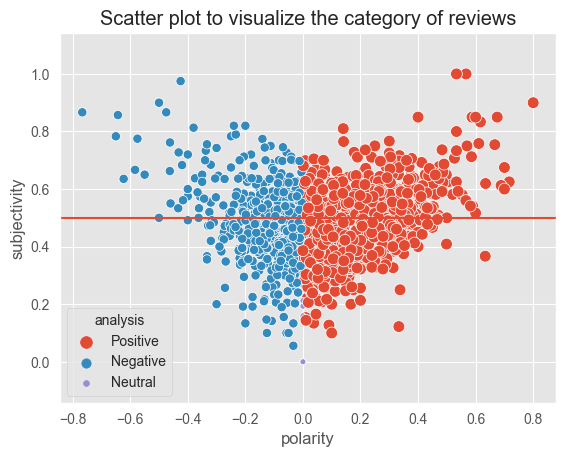

In [36]:
def subjectivity(text):
    '''
    function to calculate subjectivity score of the review
    '''
    return TextBlob(text).sentiment.subjectivity

def polarity(text):
    '''
    function to calculate polarity score of the review
    '''
    return TextBlob(text).sentiment.polarity

def getAnalysis(score):
    ''''
    function to get the review category from the polarity score
    '''
    if score < 0:
        return 'Negative'
    elif score == 0:
        return 'Neutral'
    else:
        return 'Positive'

df['subjectivity'] = df['review'].apply(subjectivity)
df['polarity'] = df['review'].apply(polarity)
df['analysis'] = df['polarity'].apply(getAnalysis)

sns.scatterplot(df,
                x ='polarity',
                y='subjectivity',
                hue='analysis',
                size = 'analysis')
plt.axhline(0.5) # add a vertical line at x=0 for Netural Reviews
plt.title('Scatter plot to visualize the category of reviews')
plt.axis('equal')
plt.show()